In [2]:
import zipfile
import os

# Define the path to the uploaded zip file
zip_file_path = "D:\dataset and all.zip"
extract_dir = "D:\dataset and all"

# Create a directory to extract the zip file
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files
extracted_files = os.listdir(extract_dir)
extracted_files

['submission_format.csv',
 'test_set_features.csv',
 'training_set_features.csv',
 'training_set_labels.csv']

In [3]:
import pandas as pd

# Define file paths
training_features_path = os.path.join(extract_dir, 'training_set_features.csv')
training_labels_path = os.path.join(extract_dir, 'training_set_labels.csv')

# Load the training set features and labels
train_features = pd.read_csv(training_features_path)
train_labels = pd.read_csv(training_labels_path)

# Display the first few rows of the training features
train_features.head()


,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [4]:
# Display the first few rows of the training labels
train_labels.head()


,respondent_id,xyz_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Load the datasets
train_features = pd.read_csv("D:\\dataset_and_all\\training_set_features.csv")
train_labels = pd.read_csv("D:\\dataset_and_all\\training_set_labels.csv")

# Separate features and labels
X = train_features.drop(columns=['respondent_id'])
y = train_labels.drop(columns=['respondent_id'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Preprocessing pipelines for numerical and categorical data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Create a pipeline with preprocessing and the classifier
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(random_state=42)))
])

# Train the model
model.fit(X_train, y_train)

# Predict probabilities on the validation set
y_pred_probs = model.predict_proba(X_val)
y_pred_probs_combined = pd.DataFrame({
    'xyz_vaccine': y_pred_probs[0][:, 1],
    'seasonal_vaccine': y_pred_probs[1][:, 1]
})

# Calculate ROC AUC scores
roc_auc_xyz = roc_auc_score(y_val['xyz_vaccine'], y_pred_probs_combined['xyz_vaccine'])
roc_auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_pred_probs_combined['seasonal_vaccine'])

# Average ROC AUC score
average_roc_auc = (roc_auc_xyz + roc_auc_seasonal) / 2

print('ROC AUC for xyz vaccine:', roc_auc_xyz)
print('ROC AUC for seasonal vaccine:', roc_auc_seasonal)
print('Average ROC AUC:', average_roc_auc)


ROC AUC for xyz vaccine: 0.8294325525888947
ROC AUC for seasonal vaccine: 0.8518072872366175
Average ROC AUC: 0.8406199199127561


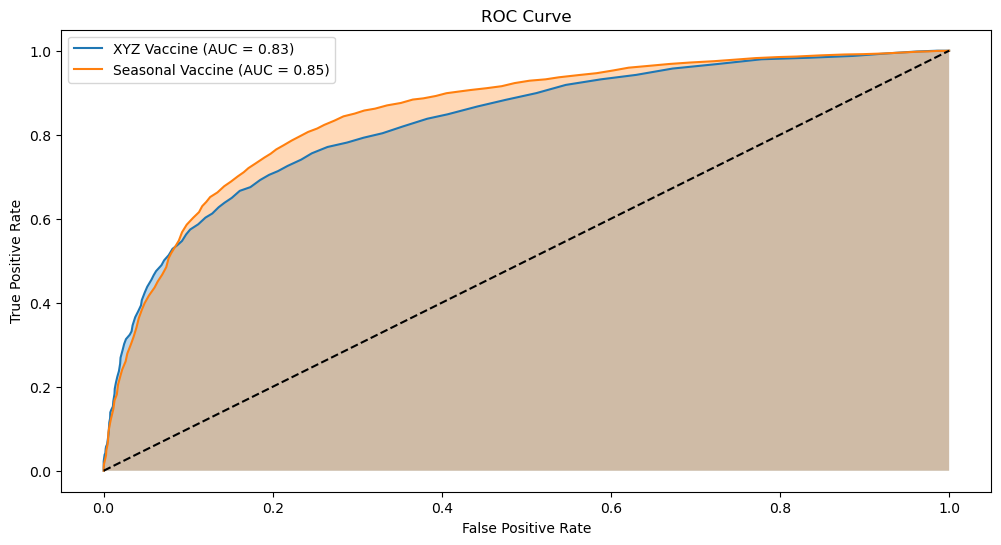

In [6]:
# Plot ROC curves
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

fpr_xyz, tpr_xyz, _ = roc_curve(y_val['xyz_vaccine'], y_pred_probs_combined['xyz_vaccine'])
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_val['seasonal_vaccine'], y_pred_probs_combined['seasonal_vaccine'])

plt.figure(figsize=(12, 6))
plt.plot(fpr_xyz, tpr_xyz, label='XYZ Vaccine (AUC = {:.2f})'.format(roc_auc_xyz))
plt.fill_between(fpr_xyz, tpr_xyz, alpha=0.3)
plt.plot(fpr_seasonal, tpr_seasonal, label='Seasonal Vaccine (AUC = {:.2f})'.format(roc_auc_seasonal))
plt.fill_between(fpr_seasonal, tpr_seasonal, alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [7]:

test_features = pd.read_csv("D:\\dataset_and_all\\test_set_features.csv")
submission_format = pd.read_csv("D:\\dataset_and_all\\submission_format.csv")
# Predict probabilities on the test set
test_ids = test_features['respondent_id']
X_test = test_features.drop(columns=['respondent_id'])
test_pred_probs = model.predict_proba(X_test)
test_pred_probs_combined = pd.DataFrame({
    'respondent_id': test_ids,
    'xyz_vaccine': test_pred_probs[0][:, 1],
    'seasonal_vaccine': test_pred_probs[1][:, 1]
})

# Save the predictions to a CSV file
submission_file_path = 'D:\\dataset_and_all\\submission.csv'
test_pred_probs_combined.to_csv(submission_file_path, index=False)

print('Submission file saved to', submission_file_path)

Submission file saved to D:\dataset_and_all\submission.csv
